# Ground State of the 1D Transverse-Field Ising Model without NetKet

**Goal.** Rebuild the core of NetKet’s machinery **from scratch** to see what’s inside:
1) **Analytic ansätze** (Mean-Field, Jastrow) with a hand-written VMC loop (no autodiff).  
2) **Neural Network ansatz (RBM)**, still without autodiff, inserted into the same VMC.  
3) **Autoregressive models (RNN, Masked-CNN)** with exact sampling and PyTorch autograd.

This notebook complements `ising.ipynb` (NetKet version). By implementing the same ideas here, we expose the interfaces that NetKet abstracts away:  
- how $ \log \psi_\theta(s)$ is evaluated and differentiated,  
- how configurations are sampled,  
- how the energy and its gradient are estimated.

**What is *not* the goal.** Highly optimized code. The aim is clarity of the variational principle and model behavior.



# 1. VMC for the TFIM (baseline without autodiff)

We solve the 1D TFIM with periodic boundary conditions
$$
H = J \sum_i \sigma_i^z \sigma_{i+1}^z \;-\; \Gamma \sum_i \sigma_i^x,
$$
using **Variational Monte Carlo** (VMC). The baseline uses hand-coded:
- analytic ansätze (Mean-Field, Jastrow),
- a Metropolis sampler with single-spin flips,
- local-energy evaluation and the standard stochastic gradient of the energy.

For benchmarking, we also compute the exact ground-state energy by sparse diagonalization.


In [1]:
import numpy as np
from dataclasses import dataclass
from typing import Callable, Tuple, Optional, Dict
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

In [2]:
# Generate Ns independent spin configurations of length N (±1),
# returned as a matrix of shape (N, Ns). Each column = one configuration.

def rand_spins(N: int, Ns: int, rng: np.random.Generator) -> np.ndarray:
    """Spins in {-1,+1}, shape (N, Ns)."""
    return rng.choice(np.array([-1, 1], dtype=int), size=(N, Ns))

### Variational Ansätze

An ansatz defines a parametrized family of wavefunctions \(\psi_\theta(s)\).  
It must provide:
- the number of parameters,
- the log-amplitude,
- its gradient with respect to the parameters,
- the local change in log-amplitude when flipping a spin.

We implement:

- **Mean-Field ansatz**:  

$$
\log \psi(s) = \sum_i h_i s_i
$$

- **Jastrow ansatz** (range \(R\)):  

$$
\log \psi(s) = \sum_{r=1}^R J_r \sum_i s_i s_{i+r}
$$


In [3]:
class Ansatz:
    """
    Minimal API every ansatz must provide:
    - n_params(N): number of variational parameters for system size N
    - logpsi(theta, S): batched log |ψθ(s)| for S of shape (N, Ns) → (Ns,)
    - grad_logpsi(theta, S): ∂θ logψ as (P, Ns), P = n_params(N)
    - delta_logpsi_flip(theta, S, i): Δlogψ when flipping spin i in each column (length Ns)
    """
    def n_params(self, N: int) -> int: ...
    def logpsi(self, theta: np.ndarray, S: np.ndarray) -> np.ndarray: ...
    def grad_logpsi(self, theta: np.ndarray, S: np.ndarray) -> np.ndarray: ...
    def delta_logpsi_flip(self, theta: np.ndarray, S: np.ndarray, i: np.ndarray) -> np.ndarray: ...

In [4]:
@dataclass
class MeanField(Ansatz):
    """
    log ψ(s) = Σ_i h_i s_i
    θ = [h_0, ..., h_{N-1}]
    """
    def n_params(self, N: int) -> int: return N

    def logpsi(self, theta: np.ndarray, S: np.ndarray) -> np.ndarray:
        # S: (N, Ns) ; theta: (N,)
        return S.T @ theta

    def grad_logpsi(self, theta: np.ndarray, S: np.ndarray) -> np.ndarray:
        # O_k(s) = ∂ logψ / ∂ h_k = s_k
        return S.astype(float)  # (N, Ns)

    def delta_logpsi_flip(self, theta: np.ndarray, S: np.ndarray, i: np.ndarray) -> np.ndarray:
        # Flipping s_i -> -s_i changes s_i by (-2 s_i), so Δlogψ = (h_i)(-s_i - s_i) = -2 h_i s_i
        Ns = S.shape[1]
        cols = np.arange(Ns)
        return -2.0 * theta[i] * S[i, cols]

In [5]:
@dataclass
class JastrowJn(Ansatz):
    """
    log ψ(s) = Σ_{r=1..R} J_r Σ_i s_i s_{i+r}
    θ = [J_1, ..., J_R]
    periodic boundary conditions
    """
    R: int  # max neighbor range

    def n_params(self, N: int) -> int: return self.R

    def logpsi(self, theta: np.ndarray, S: np.ndarray) -> np.ndarray:
        N, Ns = S.shape
        out = np.zeros(Ns)
        for r, Jr in enumerate(theta, start=1):
            out += Jr * np.sum(S * np.roll(S, -r, axis=0), axis=0)
        return out

    def grad_logpsi(self, theta: np.ndarray, S: np.ndarray) -> np.ndarray:
        # O_r(s) = Σ_i s_i s_{i+r}
        N, Ns = S.shape
        O = np.empty((self.R, Ns))
        for r in range(1, self.R + 1):
            O[r-1] = np.sum(S * np.roll(S, -r, axis=0), axis=0)
        return O

    def delta_logpsi_flip(self, theta: np.ndarray, S: np.ndarray, i: np.ndarray) -> np.ndarray:
        """
        Efficient local Δlogψ under flipping spin at site i per column:
        For each r, only bonds touching i contribute:
          bonds: (i-r, i) and (i, i+r)
        Before flip:  s_{i-r}s_i + s_i s_{i+r}
        After flip : -s_{i-r}s_i - s_i s_{i+r}
        Δ (each r-term) = -2 J_r s_i ( s_{i-r} + s_{i+r} )
        Sum over r
        """
        N, Ns = S.shape
        cols = np.arange(Ns)
        si = S[i, cols]
        delta = np.zeros(Ns, dtype=float)
        for r, Jr in enumerate(theta, start=1):
            im = (i - r) % N
            ip = (i + r) % N
            delta += -2.0 * Jr * si * (S[im, cols] + S[ip, cols])
        return delta


### Monte Carlo Sampling

We use the Metropolis–Hastings algorithm with single-spin flips to sample configurations 
from $|\psi_\theta(s)|^2$.

In [6]:
def metropolis_single_flip(
    ansatz: Ansatz,
    theta: np.ndarray,
    N: int,
    Ns: int,
    steps: int,
    burnin: int = 200,
    thin: int = 1,
    seed: Optional[int] = None,
) -> np.ndarray:
    """
    Single-spin-flip Metropolis. We propose 1 site per column at each step.
    Acceptance ratio uses Δlogψ: accept with prob min(1, exp(2 Δlogψ)).
    We only return the final thinned batch; storing full chains is optional.
    """
    rng = np.random.default_rng(seed)
    S = rand_spins(N, Ns, rng)
    cols = np.arange(Ns)

    total = burnin + steps * thin
    for t in range(total):
        i_flip = rng.integers(0, N, size=Ns)           # one proposed site per column
        dlog = ansatz.delta_logpsi_flip(theta, S, i_flip)
        acc = np.exp(2.0 * dlog)                       # ratio of |ψ|^2
        u = rng.random(Ns)
        accept = acc > u
        if np.any(accept):
            S[i_flip[accept], cols[accept]] *= -1
        # If you wanted to collect a chain, sample every 'thin' steps here
    return S


### Energy evaluation

The VMC energy estimator is the average of the **local energy**:

$$
E_\text{loc}(s) = \frac{\langle s| H |\psi \rangle}{\langle s|\psi\rangle}.
$$



In [7]:
def tfim_local_energy(S: np.ndarray, ansatz: Ansatz, theta: np.ndarray, J: float, Gamma: float) -> np.ndarray:
    """
    Local energy for TFIM with PBC:
      E_loc(s) = J Σ_i s_i s_{i+1}  -  Γ Σ_i [ ψ(s^flip_i)/ψ(s) ]
                = J Σ_i s_i s_{i+1}  -  Γ Σ_i exp(Δlogψ_i)
    Vectorized over columns in S.
    """
    N, Ns = S.shape
    # diagonal part
    diag = J * np.sum(S * np.roll(S, -1, axis=0), axis=0)  # (Ns,)

    # off-diagonal via M ratios
    cols = np.arange(Ns)
    off = np.zeros(Ns, dtype=float)
    for i in range(N):
        i_vec = np.full(Ns, i, dtype=int)                  # flip site i in every column
        dlog = ansatz.delta_logpsi_flip(theta, S, i_vec)   # (Ns,)
        off += np.exp(dlog)
    return diag - Gamma * off

In [8]:
def exact_gs_energy_sparse(N: int, J: float, Gamma: float) -> float:
    """
    Exact ground-state energy with a bit-operator sparse construction (works up to ~N=20 comfortably).
    Basis: computational |σ^z> basis encoded as integers 0..2^N-1.
    H = J Σ_i Z_i Z_{i+1} - Γ Σ_i X_i
    """
    dim = 1 << N
    rows, cols, data = [], [], []

    def add(r, c, v):
        rows.append(r); cols.append(c); data.append(v)

    # Diagonal part: J Σ_i z_i z_{i+1}, where z_i = ±1
    for state in range(dim):
        z = 0.0
        s = state
        # compute Σ_i z_i z_{i+1} with PBC using bits
        # map bit b∈{0,1} to z=+1 if 0, -1 if 1 => z = 1 - 2b
        for i in range(N):
            b_i  = (s >> i) & 1
            b_ip = (s >> ((i + 1) % N)) & 1
            z_i  = 1 - 2*b_i
            z_ip = 1 - 2*b_ip
            z += z_i * z_ip
        add(state, state, J * z)

    # Off-diagonal: -Γ Σ_i X_i flips bit i
    for state in range(dim):
        for i in range(N):
            flipped = state ^ (1 << i)
            add(state, flipped, -Gamma)

    H = csr_matrix((data, (rows, cols)), shape=(dim, dim))
    # Smallest algebraic eigenvalue
    w, _ = eigsh(H, k=1, which="SA")
    return float(w[0])

# Gradient of the energy

The stochastic gradient of the energy with respect to variational parameters is

$$
\nabla_\theta E = 2 \, \langle O(s) \, (E_\text{loc}(s) - \langle E\rangle) \rangle,
$$

where $O(s) = \nabla_\theta \log \psi_\theta(s)$.


In [9]:
def eloc_and_grad(
    S: np.ndarray,
    ansatz: Ansatz,
    theta: np.ndarray,
    J: float,
    Gamma: float,
) -> Tuple[float, np.ndarray]:
    # Compute local energies for each sample configuration
    # Shape: Eloc = (Ns,), one value per column of S
    Eloc = tfim_local_energy(S, ansatz, theta, J, Gamma)

    # Monte Carlo estimate of the mean energy ⟨E⟩
    E_mean = float(np.mean(Eloc))

    # Log-derivatives O(s) = ∂θ log ψθ(s)
    # Shape: (P, Ns), with P = number of variational parameters
    O = ansatz.grad_logpsi(theta, S)

    # Stochastic gradient estimator:
    # ∇θ E = 2 ⟨ O(s) · (E_loc(s) − ⟨E⟩) ⟩
    # Broadcasting (Eloc - E_mean)[None,:] gives shape (1, Ns) for subtraction
    grad = 2.0 * np.mean(O * (Eloc - E_mean)[None, :], axis=1)  # (P,)

    # Return both the mean energy and the gradient vector
    return E_mean, grad


## VMC optimization loop

We implement a simple **stochastic gradient descent (SGD)** scheme.  
At each iteration:
1. Sample spin configurations with current parameters.
2. Estimate energy and its gradient.
3. Update parameters.

We also allow a live callback to monitor convergence.


In [10]:
def vmc(
    N, Ns, J, Gamma, ansatz, lr, N_opt,
    sampler_kwargs=None, theta0=None,
    verbose=10, callback=None, callback_every=1
):
    """
    Variational Monte Carlo optimization loop with stochastic gradient descent.

    Args:
        N            : number of spins
        Ns           : number of samples per iteration
        J, Gamma     : TFIM Hamiltonian parameters
        ansatz       : variational ansatz object (provides logpsi, grad, delta_logpsi_flip)
        lr           : learning rate (SGD step size)
        N_opt        : number of optimization iterations
        sampler_kwargs : dict of arguments passed to Metropolis sampler
        theta0       : optional initial parameters (default = zeros)
        verbose      : print frequency (in steps); 0 = silent
        callback     : optional function called during optimization for live monitoring
        callback_every : call callback every k steps

    Returns:
        E_hist : array of shape (N_opt,) with mean energy at each iteration
        theta  : final optimized variational parameters
    """
    sampler_kwargs = sampler_kwargs or {}

    # Number of variational parameters for this ansatz
    P = ansatz.n_params(N)

    # Initialize parameters (default = zeros, symmetric start)
    theta = np.zeros(P) if theta0 is None else theta0.astype(float)

    # Store energy estimates across optimization steps
    E_hist = np.zeros(N_opt, dtype=float)

    for t in range(N_opt):
        # 1) Sample spin configurations with current parameters
        S = metropolis_single_flip(ansatz, theta, N, Ns, **sampler_kwargs)

        # 2) Estimate mean energy and gradient on this batch
        E_mean, grad = eloc_and_grad(S, ansatz, theta, J, Gamma)

        # 3) Record energy in history
        E_hist[t] = E_mean

        # 4) Gradient descent update: θ ← θ - lr * ∇E
        theta -= lr * grad

        # Optional: print diagnostics every "verbose" steps
        if verbose and (t % verbose == 0):
            print(f"[{t:4d}] E = {E_mean:.6f} |grad| = {np.linalg.norm(grad):.3e}")

        # Optional: call live plotting/logging function
        if callback and (t % callback_every == 0):
            callback(t, E_mean, theta, E_hist[:t+1])

    # Return energy trajectory and final optimized parameters
    return E_hist, theta


### Live plotting

For visualization, we define a `LiveEnergyClear` class that refreshes the energy plot at each step,
using Jupyter’s `clear_output`. This shows convergence in real-time.


In [11]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

class LiveEnergyClear:
    """
    Live plotting utility for VMC optimization inside a Jupyter notebook.

    Usage:
        live = LiveEnergyClear(E_exact=E0)
        vmc(..., callback=live, callback_every=1)

    At each call, the previous figure is cleared and replaced with an updated
    energy vs iteration plot, so you see convergence in real time.
    """
    def __init__(self, E_exact=None):
        # Optional exact energy value for comparison (drawn as dashed line)
        self.E_exact = E_exact

    def __call__(self, step, E_mean, theta, E_hist):
        # Clear previous output to avoid stacking plots
        clear_output(wait=True)

        # Create a new figure
        fig, ax = plt.subplots(figsize=(6,4))

        # Plot energy history so far
        ax.plot(E_hist, lw=2, label="VMC")

        # If known, show the exact ground-state energy as a horizontal line
        if self.E_exact is not None:
            ax.axhline(self.E_exact, ls="--", c="red",
                       label=f"Exact {self.E_exact:.6f}")

        # Label axes and add a title with current step & energy
        ax.set_xlabel("Step")
        ax.set_ylabel("Energy")
        ax.set_title(f"Step {step}   E = {E_mean:.6f}")
        ax.legend()

        # Display the figure inline and close it (to avoid memory leaks)
        display(fig)
        plt.close(fig)


## Results of the traditional ansatz

We now run the VMC for the Jastrow ansatz with range \(R=2\), and compare with exact diagonalization.


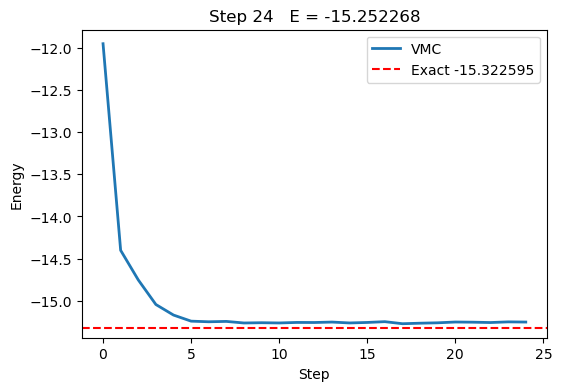

E_VMC ≈ -15.25226764875891  | E_exact = -15.322595151080801  | Relative error = -0.004589790543211657


In [12]:
# Problem setup
N, J, Gamma, Ns = 12, 1.0, 1.0, 512   # N: spins; J, Gamma: TFIM params; Ns: samples per VMC step

# Choose the variational family (uncomment one)
ans = JastrowJn(R=2)                  # Jastrow with range R=2 (J1 + J2 parameters)
# ans = MeanField()                   # Mean-field baseline

# Exact GS energy for benchmarking (feasible up to ~N≈20 here)
E_exact = exact_gs_energy_sparse(N, J, Gamma)

# Live plotter to visualize convergence vs the exact line
live = LiveEnergyClear(E_exact=E_exact)

# Run VMC (SGD) with MCMC sampling
E_hist, theta_opt = vmc(
    N=N, Ns=Ns, J=J, Gamma=Gamma,
    ansatz=ans,
    lr=0.02,                 # learning rate (try 0.01–0.05; too large can bounce)
    N_opt=25,                # optimization iterations (increase for better convergence)
    sampler_kwargs=dict(
        steps=200,           # MCMC steps after burn-in (more → lower variance per step)
        burnin=200,          # initial burn-in to equilibrate the chain
        seed=42              # reproducible runs
        # thin=1             # (optional) keep every 'thin'-th step if you add thinning
    ),
    verbose=0,               # print every 'verbose' steps (0 = silent)
    callback=live,           # live plot with clear_output
    callback_every=1         # call the callback each iteration (use 5–10 if flicker/overhead)
)

print("E_VMC ≈", E_hist[-1], " | E_exact =", E_exact, " | Relative error =", (E_hist[-1]-E_exact)/E_exact)



## 2. Neural-Network Ansatz: Restricted Boltzmann Machine (RBM)

It was the first NQS to show that shallow neural nets can represent non-trivial quantum states (Carleo & Troyer, 2017).  
We keep the same VMC loop as above and do not use autodiff. Instead, we hand-derive:

- $\log\psi(s) = a\!\cdot\!s + \sum_j \log\cosh\big(b_j + (W_j\!\cdot\!s)\big)$,
- the log-derivatives $O(s)$ for $(a,b,W)$,
- the local $\Delta\log\psi$ used by Metropolis.

This mirrors NetKet’s classical `RBM` pathway, but with explicit arrays and gradients, making the estimator and updates fully transparent.


In [13]:
import numpy as np
from dataclasses import dataclass

@dataclass
class RBM(Ansatz):
    """
    Real-valued RBM NQS for spins s_i ∈ {−1, +1}.
    log ψ(s) = a·s + ∑_j log cosh( b_j + (W_j · s) )
    Params θ = (a ∈ R^N, b ∈ R^M, W ∈ R^{M×N}), with M = alpha*N (rounded)
    """
    alpha: float = 1.0  # hidden density (M = round(alpha*N))

    # ---- helpers to pack/unpack θ ----
    def _sizes(self, N):
        M = int(round(self.alpha * N))
        P = N + M + M * N
        return M, P

    def _unpack(self, theta, N):
        M, P = self._sizes(N)
        a = theta[:N]
        b = theta[N:N+M]
        W = theta[N+M:].reshape(M, N)
        return a, b, W

    # ---- API ----
    def n_params(self, N: int) -> int:
        M, P = self._sizes(N)
        return P

    def logpsi(self, theta: np.ndarray, S: np.ndarray) -> np.ndarray:
        """
        S: (N, Ns) spins in {-1, +1}
        returns: (Ns,) log-amplitudes
        """
        N, Ns = S.shape
        a, b, W = self._unpack(theta, N)
        # a·s
        part1 = S.T @ a  # (Ns,)
        # θ = b + W s for each column
        theta_h = b[:, None] + W @ S  # (M, Ns)
        part2 = np.sum(np.log(np.cosh(theta_h)), axis=0)  # (Ns,)
        return part1 + part2

    def grad_logpsi(self, theta: np.ndarray, S: np.ndarray) -> np.ndarray:
        """
        Returns O(s) as (P, Ns):
        O_a_i = s_i
        O_b_j = tanh(θ_j)
        O_W_ji = s_i * tanh(θ_j)
        """
        N, Ns = S.shape
        a, b, W = self._unpack(theta, N)
        M = b.size

        # precompute hidden pre-activations and tanh
        theta_h = b[:, None] + W @ S            # (M, Ns)
        T = np.tanh(theta_h)                    # (M, Ns)

        # allocate O with correct total size
        P = self.n_params(N)
        O = np.empty((P, Ns), dtype=float)

        # a-part
        O[:N, :] = S.astype(float)

        # b-part
        O[N:N+M, :] = T

        # W-part: each row j contributes S * T[j,:]
        # reshape to (M, N, Ns) then flatten to (M*N, Ns)
        OW = (T[:, None, :] * S[None, :, :]).reshape(M * N, Ns)
        O[N+M:, :] = OW
        return O

    def delta_logpsi_flip(self, theta: np.ndarray, S: np.ndarray, i: np.ndarray) -> np.ndarray:
        """
        Vectorized local change in log ψ when flipping spin at site i (length Ns).
        For flip at site i:
          Δ(log ψ) = -2 a_i s_i  +  ∑_j [ log cosh(θ_j - 2 W_{ji} s_i) - log cosh(θ_j) ]
        where θ_j = b_j + (W_j · s).
        i may be a scalar per column or a length-Ns vector of indices.
        """
        N, Ns = S.shape
        a, b, W = self._unpack(theta, N)
        cols = np.arange(Ns)

        # handle i as vector of length Ns
        if np.isscalar(i):
            i = np.full(Ns, int(i), dtype=int)

        # current hidden pre-activations for each sample
        theta_h = b[:, None] + W @ S            # (M, Ns)

        # pull values for the flipped site
        si = S[i, cols]                         # (Ns,)
        Wij = W[:, i]                           # (M, Ns) via broadcasting after gather

        # Because i differs per column, gather W_{:, i[c]} per column:
        # build (M, Ns) matrix of column-wise W[:, i_c]
        Wij_cols = W[np.arange(W.shape[0])[:, None], i[None, :]]  # (M, Ns)

        # θ' = θ - 2 W_{:,i} * s_i   (broadcast over j for each column)
        theta_h_new = theta_h - 2.0 * Wij_cols * si[None, :]

        # Δ log ψ
        delta_hidden = np.sum(np.log(np.cosh(theta_h_new)) - np.log(np.cosh(theta_h)), axis=0)  # (Ns,)
        delta_visible = -2.0 * a[i] * si                                                        # (Ns,)
        return delta_visible + delta_hidden


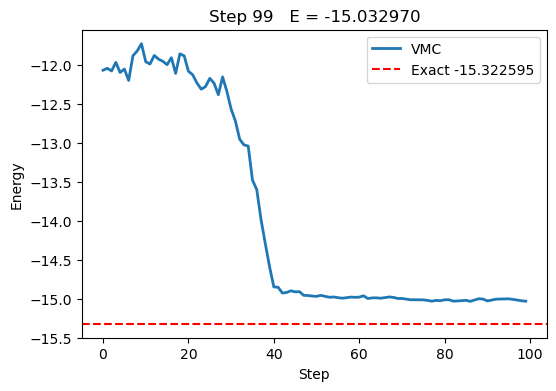

E_VMC ≈ -15.032970304185962  | E_exact = -15.322595151080776  | Relative error = -0.018901814218747735


In [14]:
# Problem
N, J, Gamma, Ns = 12, 1.0, 1.0, 512

# Choose the NQS
ans = RBM(alpha=1)   # try 0.5–2.0

# Init params (zeros is fine; small random helps exploration)
P = ans.n_params(N)
theta0 = 0.01 * np.random.randn(P)

# Exact for reference
E_exact = exact_gs_energy_sparse(N, J, Gamma)
live = LiveEnergyClear(E_exact=E_exact)

# Run your existing VMC (works as-is)
E_hist, theta_opt = vmc(
    N=N, Ns=Ns, J=J, Gamma=Gamma, ansatz=ans,
    lr=0.02, N_opt=100,
    sampler_kwargs=dict(steps=200, burnin=400, seed=42),
    theta0=theta0,
    verbose=5, callback=live, callback_every=1
)
print("E_VMC ≈", E_hist[-1], " | E_exact =", E_exact, " | Relative error =", (E_hist[-1]-E_exact)/E_exact)


## 3. Autoregressive Models (exact sampling): RNN and Masked-CNN

**Motivation.** MCMC introduces correlation and mixing issues. Autoregressive models (introduced by Sharir, Levine, Wies, Carleo, Shashua, 2020) parameterize the Born probability
$$
|\psi_\theta(s)|^2 \;=\; \prod_{i=1}^N P_\theta\!\big(s_i \,\big|\, s_1,\dots,s_{i-1}\big),
$$
so we can sample exactly by ancestral sampling. We then set
$$
\log\psi_\theta(s) \;=\; \tfrac{1}{2}\sum_{i=1}^N \log P_\theta\!\big(s_i \mid s_{<i}\big).
$$

**Architectures.**
- **AR-RNN (GRU):** sequential conditionals, natural for 1D chains.
- **AR-MaskedCNN (PixelCNN-style):** masked 1D convolutions enforce autoregressive causality while evaluating all sites in parallel.

**Training.** We use the same variational objective as before, now with **PyTorch autograd**:
- sample ancestrally from the current model,
- compute $E_{\text{loc}}$ (stop-grad),
- backprop through $\log\psi$ only.

The variational principle is the same; only the sampler and parameterization change. This mirrors NetKet’s `ARNN`/NAQS style interfaces.


In [15]:
# ---- PyTorch helpers ----
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.bernoulli import Bernoulli

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def np_to_t(x): return torch.from_numpy(x).to(device)
def t_to_np(x): return x.detach().cpu().numpy()


In [16]:
class ARBase:
    """
    Common interface:
      - logpsi_np(S_np): returns (Ns,) np array of logψ(s)
      - delta_logpsi_flip_np(S_np, i_vec): returns (Ns,) Δlogψ for flipping site i in each column
      - sample_direct(N, Ns): ancestral sampling → np array (N, Ns) with spins in {-1,+1}
      - parameters(): torch parameters iterator (for optimizer)
    Convention: inputs/outputs are batched over Ns (columns).
    """
    def logpsi_np(self, S_np: np.ndarray) -> np.ndarray: ...
    def delta_logpsi_flip_np(self, S_np: np.ndarray, i_vec: np.ndarray) -> np.ndarray: ...
    def sample_direct(self, N: int, Ns: int, seed: int = 0) -> np.ndarray: ...
    def parameters(self): ...

class ARShim:
    """
    Adapts ARBase to the 'Ansatz' API used by tfim_local_energy:
      - delta_logpsi_flip(theta,S,i_vec) -> uses AR.delta_logpsi_flip_np(S,i_vec)
    """
    def __init__(self, ar_model: ARBase):
        self.ar = ar_model
    def delta_logpsi_flip(self, theta, S, i_vec):
        return self.ar.delta_logpsi_flip_np(S, i_vec)


In [17]:
def vmc_ar(
    N:int, J:float, Gamma:float,
    model: ARBase,
    Ns:int = 1024,
    iters:int = 200,
    lr:float = 1e-3,
    seed:int = 0,
    callback=None, callback_every:int = 1,
):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    E_hist = []

    for t in range(iters):
        # 1) Direct ancestral sampling from current model
        S_np = model.sample_direct(N=N, Ns=Ns, seed=seed+t)   # (N, Ns)

        # 2) Local energies (stop-grad): use ARShim for Δlogψ
        shim = ARShim(model)
        Eloc = tfim_local_energy(S_np, shim, None, J, Gamma)  # (Ns,)
        E_mean = float(np.mean(Eloc))
        E_hist.append(E_mean)

        # 3) Variational gradient via ∑ 2 (E_loc - Ē) log ψ
        #    (Don't backprop through Eloc; treat it as constant targets.)
        S_t = ARRNN.spin_to_tensor(S_np) if isinstance(model, ARRNN) else ARMaskedCNN.spin_to_tensor(S_np)
        # recompute logψ with grad:
        logits = (model.conditionals_logits(S_t).squeeze(-1)
                  if isinstance(model, ARRNN)
                  else model.logits_all(S_np))
        p = torch.sigmoid(logits)                        # (Ns, N)
        s = torch.transpose(np_to_t(S_np.astype(np.float32)), 0, 1)  # (Ns, N)
        p_si = torch.where(s>0, p, 1.0 - p)
        logpsi = 0.5 * torch.sum(torch.log(p_si + 1e-12), dim=1)     # (Ns,)

        Eloc_t = np_to_t(Eloc.astype(np.float32))
        Ebar = torch.mean(Eloc_t)
        loss = torch.mean( 2.0 * (Eloc_t - Ebar).detach() * (logpsi) ) 

        opt.zero_grad()
        loss.backward()
        opt.step()

        if callback and (t % callback_every == 0):
            callback(t, E_mean, None, np.array(E_hist))

    return np.array(E_hist)


## RNN

In [18]:
class ARRNN(nn.Module, ARBase):
    def __init__(self, N: int, hidden: int = 128):
        super().__init__()
        self.N = N
        self.embed = nn.Linear(1, hidden)          # embed spin {-1,+1}
        self.gru   = nn.GRU(hidden, hidden, batch_first=True)
        self.head  = nn.Linear(hidden, 1)          # logits per site
        self.to(device)

    # ---- utilities ----
    @staticmethod
    def spin_to_tensor(S_np):
        # expects (N, Ns) in {-1,+1}; returns torch (Ns, N, 1) float
        S = np.transpose(S_np, (1,0))[:, :, None].astype(np.float32)
        return np_to_t(S)

    def conditionals_logits(self, S_prefix):
        """
        S_prefix: (Ns, N, 1) with full sequences (teacher forcing).
        Returns logits (Ns, N, 1), where logit at i only depends on positions < i.
        """
        x = self.embed(S_prefix)                   # (Ns, N, hidden)
        h, _ = self.gru(x)                         # (Ns, N, hidden)
        logits = self.head(h)                      # (Ns, N, 1)
        return logits

    # ---- log-psi ----
    def logpsi_np(self, S_np: np.ndarray) -> np.ndarray:
        with torch.no_grad():
            S = self.spin_to_tensor(S_np)          # (Ns, N, 1)
            logits = self.conditionals_logits(S)   # (Ns, N, 1)
            probs  = torch.sigmoid(logits).squeeze(-1)  # (Ns, N)
            # pick p_i according to s_i ∈ {-1,+1}
            # s=+1 -> p; s=-1 -> 1-p
            s = torch.transpose(np_to_t(S_np.astype(np.float32)), 0, 1)  # (Ns, N)
            p_si = torch.where(s>0, probs, 1.0 - probs)                  # (Ns, N)
            logP = torch.sum(torch.log(p_si + 1e-12), dim=1)             # (Ns,)
            logpsi = 0.5 * logP
            return t_to_np(logpsi)

    # ---- Δ log-psi under flip at site i (vectorized across batch) ----
    def delta_logpsi_flip_np(self, S_np: np.ndarray, i_vec: np.ndarray) -> np.ndarray:
        # Strategy: compute logpsi(s) once; build flipped batch and compute logpsi(s^flip); subtract.
        Ns = S_np.shape[1]
        logpsi = self.logpsi_np(S_np)
        S_flip = S_np.copy()
        cols = np.arange(Ns)
        S_flip[i_vec, cols] *= -1
        logpsi_flip = self.logpsi_np(S_flip)
        return logpsi_flip - logpsi

    # ---- ancestral sampler ----
    def sample_direct(self, N: int, Ns: int, seed: int = 0) -> np.ndarray:
        torch.manual_seed(seed)
        # Start with all zeros prefix;
        S = torch.zeros((Ns, N, 1), device=device)
        # convention: first site unconditional → we use network output with s_<1 empty (zero)
        for i in range(N):
            logits = self.conditionals_logits(S)[:, i, 0]  # (Ns,)
            p = torch.sigmoid(logits)
            s_i = (torch.rand_like(p) < p).float() * 2 - 1  # in {-1,+1}
            S[:, i, 0] = s_i
        # return (N, Ns) int in {-1,+1}
        return np.transpose(t_to_np(S.squeeze(-1)), (1,0)).astype(int)

    def parameters(self):
        return super().parameters()


## Masked CNN

In [19]:
class MaskedConv1d(nn.Conv1d):
    def __init__(self, in_ch, out_ch, kernel_size, mask_type: str, dilation: int = 1):
        super().__init__(in_ch, out_ch, kernel_size,
                         padding=(kernel_size//2)*dilation,
                         bias=True, dilation=dilation)
        assert mask_type in ("A","B")
        self.register_buffer("mask", torch.ones_like(self.weight))
        k = kernel_size
        center = k//2
        self.mask[:, :, center+1:] = 0.0
        if mask_type == "A":
            self.mask[:, :, center] = 0.0

    def forward(self, x):
        return F.conv1d(x, self.weight * self.mask, self.bias,
                        stride=self.stride, padding=self.padding,
                        dilation=self.dilation, groups=self.groups)

class ARMaskedCNN(nn.Module, ARBase):
    def __init__(self, N: int, channels: int = 96, kernel_size: int = 3,
                 dilations=(1,2,4,8,1,1)):
        super().__init__()
        self.N = N
        self.inp = MaskedConv1d(1, channels, kernel_size, mask_type="A", dilation=dilations[0])
        self.blocks = nn.ModuleList([
            nn.Sequential(
                MaskedConv1d(channels, channels, kernel_size, mask_type="B", dilation=d),
                nn.ReLU(),
                nn.Conv1d(channels, channels, 1),
                nn.ReLU(),
            ) for d in dilations[1:]
        ])
        self.out = nn.Conv1d(channels, 1, 1)
        self.to(device)

    @staticmethod
    def spin_to_tensor(S_np):
        return np_to_t(np.transpose(S_np, (1,0))[:, None, :].astype(np.float32))

    def logits_all(self, S_np):
        x = self.spin_to_tensor(S_np)                 # (Ns, 1, N)
        h = F.relu(self.inp(x))
        for b in self.blocks:
            h = h + b(h)                              # residual
        return self.out(h).squeeze(1)                 # (Ns, N)

    def logpsi_np(self, S_np: np.ndarray) -> np.ndarray:
        with torch.no_grad():
            logits = self.logits_all(S_np)        # (Ns, N)
            p = torch.sigmoid(logits)             # p(+1|prefix)
            s = torch.transpose(np_to_t(S_np.astype(np.float32)), 0, 1)  # (Ns, N)
            p_si = torch.where(s>0, p, 1.0 - p)
            logP = torch.sum(torch.log(p_si + 1e-12), dim=1)
            return t_to_np(0.5 * logP)

    def delta_logpsi_flip_np(self, S_np: np.ndarray, i_vec: np.ndarray) -> np.ndarray:
        Ns = S_np.shape[1]
        logpsi = self.logpsi_np(S_np)
        S_flip = S_np.copy()
        cols = np.arange(Ns)
        S_flip[i_vec, cols] *= -1
        logpsi_flip = self.logpsi_np(S_flip)
        return logpsi_flip - logpsi

    def sample_direct(self, N: int, Ns: int, seed: int = 0) -> np.ndarray:
        torch.manual_seed(seed)
        S = torch.zeros((Ns, 1, N), device=device)
        for i in range(N):
            logits = self.logits_all(t_to_np(S.squeeze(1).transpose(1,0)))[:, i]  # (Ns,)
            p = torch.sigmoid(logits)
            s_i = (torch.rand_like(p) < p).float() * 2 - 1
            S[:, 0, i] = s_i
        return np.transpose(t_to_np(S.squeeze(1)), (1,0)).astype(int)

    def parameters(self):
        return super().parameters()


## Results 

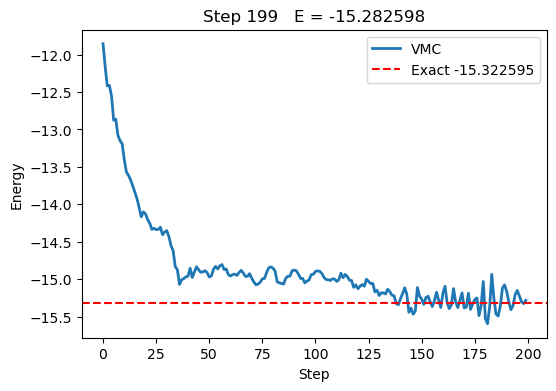

E_VMC ≈ -15.282597716650344  | E_exact = -15.32259515108081  | Relative error = -0.002610356407389973


In [20]:
# Exact reference
E_exact = exact_gs_energy_sparse(N=12, J=1.0, Gamma=1.0)
live = LiveEnergyClear(E_exact=E_exact)


# ---- AR-RNN ----
ar_rnn = ARRNN(N=12, hidden=64)
E_hist_rnn = vmc_ar(
    N=12, J=1.0, Gamma=1.0, model=ar_rnn,
    Ns=1024, iters=200, lr=1e-3,
    callback=live, callback_every=1
)

print("E_VMC ≈", E_hist_rnn[-1], " | E_exact =", E_exact, " | Relative error =", (E_hist_rnn[-1]-E_exact)/E_exact)



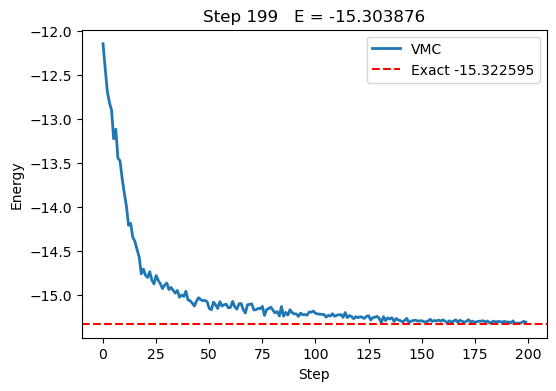

E_VMC ≈ -15.30387602749397  | E_exact = -15.32259515108081  | Relative error = -0.0012216679617433454


In [21]:
# ---- AR-MaskedCNN ----
ar_cnn = ARMaskedCNN(N=12, channels=32, kernel_size=3)
E_hist_cnn = vmc_ar(
    N=12, J=1.0, Gamma=1.0, model=ar_cnn,
    Ns=1024, iters=200, lr=1e-3,
    callback=live, callback_every=1
)

print("E_VMC ≈", E_hist_cnn[-1], " | E_exact =", E_exact, " | Relative error =", (E_hist_cnn[-1]-E_exact)/E_exact)


---

### References
- G. Carleo & M. Troyer, “Solving the quantum many-body problem with artificial neural networks,” (2017).
- O. Sharir, Y. Levine, N. Wies, G. Carleo, A. Shashua, “Deep Autoregressive Models for the Efficient Variational Simulation of Many-Body Quantum Systems,” (2020).
